In [1]:
# loading all the dependencies
import numpy as np
import pandas as pd
pd.options.display.float_format ='{:,.1f}'.format

import matplotlib.pyplot as plt
%matplotlib inline  

from IPython.display import Image
from IPython.core.display import HTML 

from scipy.stats import gmean
from scipy import integrate

from uncertainties import ufloat
from uncertainties import unumpy

from openpyxl import load_workbook

%run Utility_Functions.ipynb

## Methods and Statistics
Ranges and values with ± are given as 1 standard error of the values.

# Neutrophils
Neutrophils are the most abundant type of granulocyte. They form an essential part of the innate immune system. They are formed from stem cells inside the bone marrow. They are short-lived and highly motile, as they can enter parts of tissue where other cells cannot.
The estimate of Neutrophils daily turnover is made in two parts:
1. We've surveyed the literature for data regarding the number of neutrophils, in separation for the different stages in their differentiation from bone marrow stem cells. We concluded the total numbers of cells in each stage.
2. We gathered data regarding the lifespan of Neutrophils, from papers spreading over 50 years. It seems that old measurement methods had biases and so we based our values on recent models.
.

## Database for the results
We defing a dataframe conatinig the parameters we are interested in using a designated class defined in the Utility_Function notebook

In [2]:
neut = CellTypesResDF(['neutrophils'])

## Neutrophils numbers and distribution

Most of the Neutrophils reside in the bone marrow. They can be separated to four major groups, which correspond to different stages of their lives:
1. Mitotic pool - the stem cells and progenitor cells that undergo a mitosis, and so create new cells that in turn differentiate.
2. Post mitotic pool - the cells that still reside in the marrow but don't undergo mitosis anymore, just differentiate for several days, until they get to a mature neutrophil stage.
3. Circulating pool - mature neutrophil that circulate in the blood
4. Marginal pool - mature neutrophil that move from the blood and reside in different tissues in the body, until the die.


The next tree, taken from [Tak et al.,2013](https://www.ncbi.nlm.nih.gov/pubmed/23625199) and contain values taken from [Donohue et al.,1958](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1062840/). The tree showes the seperation of the bone marrow stages to the different pools


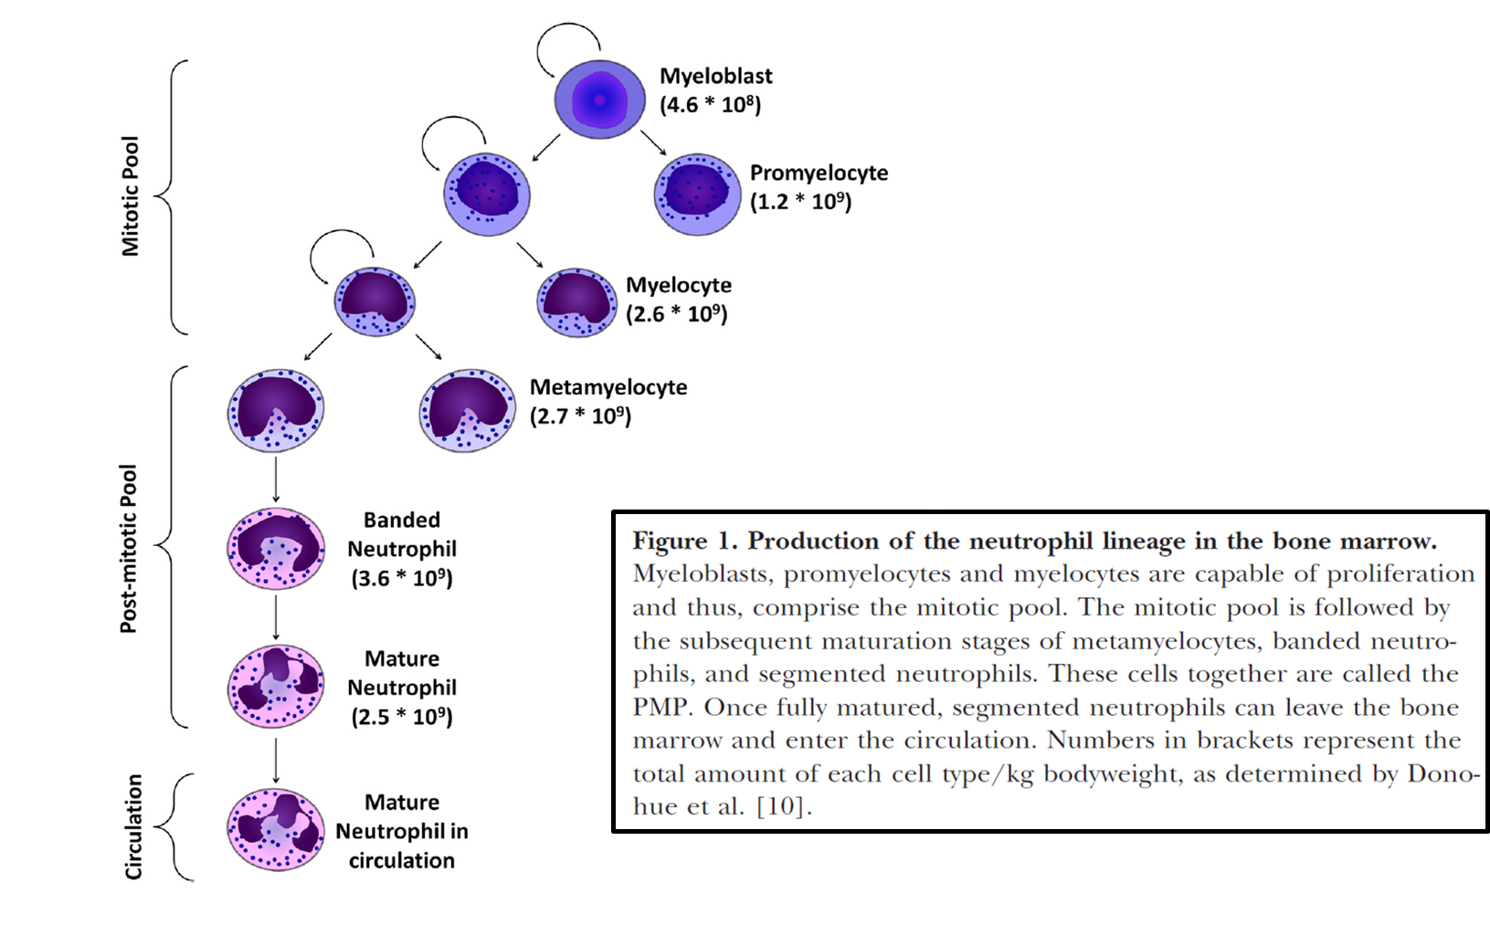

In [5]:
Image("Neutrophils_tree.png", width=600, height=375) #loading image from Tak et al.,2013

Data regarding the overall number of neutrophils and their distributions was taken from 5 sources, that spread over a 50 years period:
[Athens et al.,1961](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC290816/), 
[Harrison ,1962](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC480393/), 
[Dancey et al.,1976](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC333229/), 
[Tak et al.,2013](https://www.ncbi.nlm.nih.gov/pubmed/23625199), and 
[Lahoz-beneytez et al.,2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4929930/):

In [7]:
# Load the data regarding number of Neutrophils, diveded to the supopulations
neut_subpop_data = pd.read_excel('Neutrophils_data.xlsx',
                                 'Subpopulations',index_col=0,
                                 usecols = range(0,6), skipfooter = 7)

# neut subpop_data.drop(['Tak et al.,2013'],axis=1) #possibility to remove values that seems biased 

#computing the average and adding it as a last column
neut_subpop_data['mean'] = neut_subpop_data.mean(axis=1)

neut_subpop_data['SEM'] = neut_subpop_data.sem(axis=1)
#considering the std from the sources
neut_subpop_data.loc['blood pool','SEM'] = 0.05* neut_subpop_data.loc['blood pool','mean']
neut_subpop_data.loc['marginal pool','SEM'] = 0.05* neut_subpop_data.loc['marginal pool','mean'] 

neut_subpop_data['value per kg'] = unumpy.uarray(neut_subpop_data['mean'],neut_subpop_data['SEM'])
# neut_subpop_data.head()

Moving to total number of cells, by multypling by the reference man mass (=70kg) 

Mitotic pool contains (1.8±0.3)×10¹¹ cells
Post mitotic pool contains (4.2±0.6)×10¹¹ cells
Blood pool contains (2.1±0.1)×10¹⁰ cells
Marginal pool contains (2.1±0.1)×10¹⁰ cells
Number of neutrophils is: (6.4±0.6)×10¹¹ cells


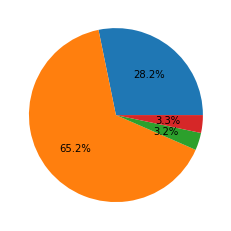

In [8]:
ref_man_mass = 70 #kg

total_neut_nums = neut_subpop_data['value per kg']*ref_man_mass*10**9
#changin units: from "10^9 cells per kg" to "cells"

#changing the format to scientific notation
pd.options.display.float_format = '{:,.1e}'.format  
total_neut_nums.index = total_neut_nums.index.rename('total number of cells:') #changing the name of the indices

plt.pie(unumpy.nominal_values(total_neut_nums), autopct='%1.1f%%')

for subp in total_neut_nums.index:
    print('{} contains {:0.1eP} cells'.format(subp.capitalize(),total_neut_nums[subp]))

neut.res['number'] = total_neut_nums.sum()
neut.print_params('number')


## Neutrophils lifespan and turnover

Neutrophils are know to be short live, and for the last decades were belived to have a half-life of less than 7 hours. However, recent studies have shown different results, some of them by orders of magnitude. 

According to [Tak et al.,2013](https://www.ncbi.nlm.nih.gov/pubmed/23625199), the old measurement that used ex vivo/ in vivo labeling method with radioactive tracers, like $DF^{32}P$  or $^{3}HTdr$ have affected the results, and were biased for low values.

In recent years some new methods were developed, using in vivo deuterium labeling $^{2}H$. This relatively new technique does label cells without cytotoxic effects. Recent papers ([Pillay et al.,2010](http://www.bloodjournal.org/content/116/4/625.long?sso-checked=true), [Lahoz-beneytez et al.,2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4929930/) ), used measurement taken by this new methods and combined it with detail models of the different pools to arrive to a more percise estimates.

It should be notice that the assumptions that make the base for detailed models, that were used to interpret the results are very important. According to [Turner et al.,2011](http://www.bloodjournal.org/content/117/22/6052.long) and [Lahoz-beneytez et al.,2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4929930/), [Pillay et al.,2010](http://www.bloodjournal.org/content/116/4/625.long?sso-checked=true) made a mistake by assuming that there is much more cell in the blood than in the mitotic pool. This mistake made them estimate a lifepan much longer than every other study (by more than an order of magnitude) 

The next table summarize several values from the literature, and the method that used to get them:


In [20]:
pd.options.display.float_format ='{:,.1f}'.format

# Load the data regarding lifespan of neutrophils
neut_lifespan_data = pd.read_excel('Neutrophils_data.xlsx',
                                   'Turnover',index_col=0,
                                   usecols = range(0,7), skipfooter = 1)
neut_lifespan_data

,half life [h],lifespan [h],post-mitotic transit time [d],post-mitotic transit time delta [d],production [10^10 cell/d],method
source,,,,,,
"Athens et al.,1961",6.6,nan,nan,nan,nan,DFP32 labeling
"Cartwright et al.,1964",6.9,nan,nan,nan,nan,DFP32 labeling
"Dancey et al.,1976 I",nan,nan,6.6,nan,6.1,"effective production, measured from circulatin..."
"Dancey et al.,1976 II",nan,nan,6.6,nan,11.3,"effective production, measured from circulatin..."
"Fliedner et al.,2002",nan,nan,nan,nan,12.0,no primary source
"Pillay et al.,2010",nan,129.6,nan,nan,nan,In vivo labeling with 2H2O
"Lahoz-beneytez et al.,2016 I",19.0,25.2,5.8,0.4,nan,"In vivo labeling with 2H2O, improved model wit..."
"Lahoz-beneytez et al.,2016 II",13.0,nan,5.7,0.4,nan,"In vivo labeling with 2H2O, improved model wit..."
"Lahoz-beneytez et al.,2016 III",16.0,nan,5.7,0.4,nan,"In vivo labeling with 2H2O, improved model for..."


As we explined, is seems that  [Pillay et al.,2010](http://www.bloodjournal.org/content/116/4/625.long?sso-checked=true) results were problematic, and so we rely on [Lahoz-beneytez et al.,2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4929930/) values.



In [21]:
#focusing only on the values from (Lahoz-beneytez et al.,2016), and removing the method column

new_ls_data = neut_lifespan_data[neut_lifespan_data.index.str.contains("Lahoz-beneytez et al.,2016")] 
new_ls_data = new_ls_data.drop(['method'], axis=1)
new_ls_data

,half life [h],lifespan [h],post-mitotic transit time [d],post-mitotic transit time delta [d],production [10^10 cell/d]
source,,,,,
"Lahoz-beneytez et al.,2016 I",19.0,25.2,5.8,0.4,nan
"Lahoz-beneytez et al.,2016 II",13.0,nan,5.7,0.4,nan
"Lahoz-beneytez et al.,2016 III",16.0,nan,5.7,0.4,nan


Calculting the lifespan from half life is easy for a simple exponent model, but not necessary for their model. We use their given value to adjust the for the simple calculted value:

In [22]:
#calculating the expected lifespan from a simple exponent model
new_ls_data['simple_ex_lifespan'] = new_ls_data['half life [h]'] / np.log(2)


#using the value for the 19h half-life to derive a correction factor 
hl2lp_factor =new_ls_data.loc['Lahoz-beneytez et al.,2016 I','lifespan [h]'] / new_ls_data.loc['Lahoz-beneytez et al.,2016 I','simple_ex_lifespan']

#multypling by the factor
new_ls_data['lifespan [h]'] = new_ls_data['simple_ex_lifespan']*hl2lp_factor
new_ls_data

,half life [h],lifespan [h],post-mitotic transit time [d],post-mitotic transit time delta [d],production [10^10 cell/d],simple_ex_lifespan
source,,,,,,
"Lahoz-beneytez et al.,2016 I",19.0,25.2,5.8,0.4,nan,27.4
"Lahoz-beneytez et al.,2016 II",13.0,17.2,5.7,0.4,nan,18.8
"Lahoz-beneytez et al.,2016 III",16.0,21.2,5.7,0.4,nan,23.1


Taking the mean as the reference lifespan in circulation and converting to time units of days:

In [23]:
circ_neut_lifespan = ufloat(new_ls_data['lifespan [h]'].mean(),
                           new_ls_data['lifespan [h]'].std())/24
print('Lifespan of neutrophil in circulation {:0.1fP}'.format(circ_neut_lifespan))

Lifespan of neutrophil in circulation 0.9±0.2


### Circulating Neutrophils turnover rate
We can obtain the total turnover rate from the number and lifespan of the circulating neutrophils:

In [25]:
total_circ_cells = total_neut_nums['blood pool']+total_neut_nums['marginal pool']
circ_turnover_rate = total_circ_cells/circ_neut_lifespan

print('Trunover rate from cicrulating nuetrophils is {:0.1eP} cells per day'.format(circ_turnover_rate))

Trunover rate from cicrulating nuetrophils is (4.8±0.9)×10¹⁰ cells per day


### PMP Neutrophils daily turnover  
We can check our resutls by looking at the post mitotic cell pool (PMP) and its transit time

In [29]:
PMP_cells = total_neut_nums['post mitotic pool']
PMP_transit_time = ufloat(new_ls_data['post-mitotic transit time [d]'].mean(),
                          new_ls_data['post-mitotic transit time [d]'].std() + new_ls_data['post-mitotic transit time delta [d]'].mean())

PMP_turnover_rate = PMP_cells/PMP_transit_time  
print('Trunover rate from PMP is {:0.1eP} cells per day'.format(PMP_turnover_rate))

Trunover rate from PMP is (7.3±1.1)×10¹⁰ cells per day


### Total lifespan and turnover rate
We take the mean of these two values to get a reference cellular turnover rate and take the reference lifespan to be the sum of the circulating cells lifespan and the PMP transit time.  

In [32]:
#computing seperatly the inter variance given from the standard error of the two values
inter_variance = np.std([circ_turnover_rate.nominal_value,
                         PMP_turnover_rate.nominal_value])/np.sqrt(2-1)

ref_nuet_turnover = (circ_turnover_rate + PMP_turnover_rate)/2 + ufloat(0,inter_variance) 

#assigning to the results dataframe
neut.res['cellular turnover rate'] = ref_nuet_turnover
neut.res['lifespan'] = PMP_transit_time + circ_neut_lifespan

neut.print_params(['cellular turnover rate','lifespan'])


Cellular turnover rate of neutrophils is: (6.0±1.5)×10¹⁰ cells per day
Lifespan of neutrophils is: 6.6±0.5 days


### Cell mass and cellular mass turnover rate
We estimate the cellular mass turnover rate using cell volume from [Ting-Beall et al.,1993](http://www.bloodjournal.org/content/81/10/2774.short)  
For the uncertainty we acount for both intra and inter variance of the two estimate

In [34]:
#mean neurtophil mass is 300±30 picogram according to (Ting-Beall et al., 1993)
neut.res['cell mass'] = ufloat(300,30)
neut.res['total cellular mass'] = neut.res['number']*neut.res['cell mass']/10**12 
neut.res['cellular mass turnover rate'] = neut.res['cell mass']*neut.res['cellular turnover rate']/10**12 

neut.print_params(['cell mass','total cellular mass','cellular mass turnover rate'])

Cell mass of neutrophils is: 300±30 pg
Total cellular mass of neutrophils is: 190±30 grams
Cellular mass turnover rate of neutrophils is: 18±5 grams per day


## Survival function and age
We use the data gather for the lifespan and transit time to plot the relevant survival function and cells age

### survival funcation
Assuming that for the PMP transit time the death rate is negleable and then a geometric decay:
{geometrical p: mean=(1-p)/p => p=1/(mean+1)}

Text(0, 0.5, '% of survival')

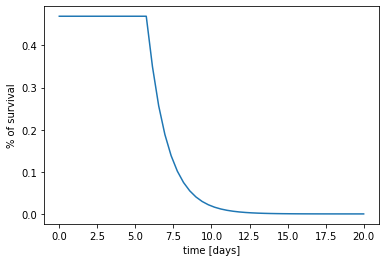

In [35]:
# Sample different time (days)
days = np.linspace(0,20)

geom_cdf = lambda n,p: 1-(1-p)**(n+1)


Sfun_geom = 1-geom_cdf(np.maximum(days-PMP_transit_time.nominal_value,0),
                       1/(1+circ_neut_lifespan.nominal_value))
Sfun_geom

# Plot the survival functions vs. the time
plt.plot(days,Sfun_geom)
plt.xlabel('time [days]')
plt.ylabel('% of survival')

### Cells age

We know that the age distribution look like the survival functio, hence we can calculate the age cdf by integrating the survival function and normalize it:

Text(0, 0.5, 'age cdf')

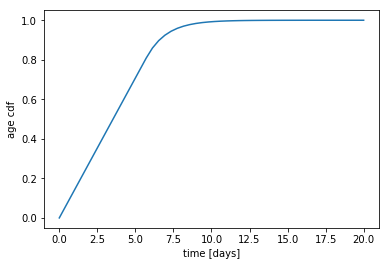

In [15]:
sf_integral = integrate.cumtrapz(Sfun_geom, days, initial=0)
age_cdf = sf_integral/max(sf_integral)
age_cdf
# Plot the age functions vs. the time
plt.plot(days,age_cdf)
plt.xlabel('time [days]')
plt.ylabel('age cdf')

## Saving the results to excell
So it can be used for summary 

In [41]:
neut.export_to_excel('Summary.xlsx')